# Informe del Proyecto

**Integrantes**

- Armando Bringas Corpus (A01200230).
- Juan Sebastián Téllez López (A01793859).
- Marcos Eduardo García Ortiz (A01276213).

**EQUIPO 13**

**MR4010 Navegación Autónoma**

**Docentes**

- Dr. David Antonio Torres.
- Mtra. Maricarmen Vázquez Rojí.
- Tutor Prof. Luis Ángel Lozano Medina**Fecha:** 22 de junio de 2024

**Título del Proyecto:** Clonación de Comportamiento para Conducción Autónoma

**Descripción:** Este informe incluye los scripts y explicaciones detalladas del proyecto de clonación de comportamiento para conducción autónoma.



## Script: behavioral_cloning_driving.py

Descripción del script.

In [ ]:
# Bibliotecas para el procesamiento de imágenes
import cv2
import numpy as np

# Biblioteca para interactuar con el sistema operativo
import os

# Bibliotecas para aprendizaje automático
from keras.models import load_model
from keras.optimizers import Adam

# Bibliotecas para el control de robots y vehículos
from controller import Robot, Camera, GPS
from vehicle import Car, Driver


class CarEngine:
    """
    La clase CarEngine encapsula la funcionalidad del motor de un coche en el contexto de una simulación.
    Incluye métodos para inicializar dispositivos, actualizar la pantalla, configurar el ángulo de dirección
    y la velocidad, actualizar el estado del coche y obtener la imagen de la cámara del coche.
    """

    def __init__(self):
        """
        Inicializa la instancia de CarEngine con valores predeterminados.
        Configura el robot, el conductor, el timestep, la cámara, el GPS, la pantalla, el ángulo,
        la velocidad y el ángulo máximo.
        """
        self.robot = Car()  # Instancia de la clase Car
        self.driver = Driver()  # Instancia de la clase Driver
        self.timestep = int(self.robot.getBasicTimeStep())  # Timestep básico del robot
        self.camera = self._initialize_device("camera")  # Inicializar el dispositivo de cámara
        self.gps = self._initialize_device("gps")  # Inicializar el dispositivo GPS
        self.display = self.robot.getDevice("display")  # Obtener el dispositivo de pantalla
        self.angle = 0.0  # Ángulo de dirección inicial
        self.speed = 25.0  # Velocidad inicial
        self.MAX_ANGLE = 0.28  # Ángulo de dirección máximo

    def _initialize_device(self, device_name):
        """
        Inicializa un dispositivo en el robot.

        Este método recupera un dispositivo del robot por su nombre, lo habilita con el timestep del robot
        y devuelve el dispositivo.

        Args:
            device_name (str): El nombre del dispositivo a inicializar.

        Returns:
            Device: El dispositivo inicializado.
        """
        device = self.robot.getDevice(device_name)  # Obtener el dispositivo del robot
        device.enable(self.timestep)  # Habilitar el dispositivo con el timestep del robot
        return device  # Devolver el dispositivo inicializado

    def update_display(self):
        """
        Actualiza la pantalla en la interfaz del robot.

        Este método recupera la velocidad actual y el ángulo de dirección del robot, los formatea en cadenas
        de texto, y los muestra en la interfaz del robot. Primero se limpia la pantalla con un color negro,
        luego se dibujan las etiquetas de velocidad y ángulo de dirección en color aguamarina,
        y los valores reales se dibujan en color blanco.

        La velocidad se muestra en km/h y el ángulo de dirección se muestra en radianes.
        """
        # Obtener la velocidad actual del robot
        speed = self.driver.getCurrentSpeed()

        # Obtener el ángulo de dirección actual del robot
        steering_angle = self.driver.getSteeringAngle()

        # Preparar las etiquetas y los valores para la velocidad y el ángulo de dirección
        speed_label_str = "Speed: "
        speed_value_str = f"{speed:.2f} km/h"
        steering_angle_label_str = "Steering Angle: "
        steering_angle_value_str = f"{steering_angle:.5f} rad"

        # Limpiar la pantalla con color negro
        self.display.setColor(0x000000)
        self.display.fillRectangle(0, 0, self.display.getWidth(), self.display.getHeight())

        # Definir los colores para las etiquetas y los valores
        aquamarine = 0x7FFFD4
        white = 0xFFFFFF

        # Dibujar las etiquetas de velocidad y ángulo de dirección en color aguamarina
        self.display.setColor(aquamarine)
        self.display.drawText(speed_label_str, 5, 10)
        self.display.drawText(steering_angle_label_str, 5, 30)

        # Dibujar los valores de velocidad y ángulo de dirección en color blanco
        self.display.setColor(white)
        self.display.drawText(speed_value_str, 50, 10)
        self.display.drawText(steering_angle_value_str, 100, 30)

    def set_steering_angle(self, value):
        """
        Configura el ángulo de dirección del coche.

        Este método toma un valor como entrada, verifica si su valor absoluto es mayor que el umbral
        de la zona muerta, y si lo es, establece el ángulo de dirección del coche al producto del ángulo
        de dirección máximo y el valor de entrada. Si el valor absoluto de la entrada no es mayor que el umbral
        de la zona muerta, el ángulo de dirección se establece en 0.

        Se espera que el valor de entrada esté en el rango de -1 a 1, y se mapea al rango de -MAX_ANGLE a MAX_ANGLE.

        Args:
            value (float): El ángulo de dirección deseado en el rango de -1 a 1.
        """
        DEAD_ZONE = 0.06
        value = value if abs(value) > DEAD_ZONE else 0.0
        # Mapear los valores de -1 a 1 a -MAX_ANGLE a MAX_ANGLE
        self.angle = self.MAX_ANGLE * value

    def set_speed(self, kmh):
        """
        Configura la velocidad de crucero del coche.

        Este método toma un valor de velocidad en kilómetros por hora (km/h) como entrada
        y establece la velocidad de crucero del coche a este valor.

        Args:
            kmh (float): La velocidad de crucero deseada en km/h.
        """
        self.speed = kmh  # Establecer la velocidad del coche
        self.driver.setCruisingSpeed(self.speed)  # Establecer la velocidad de crucero del coche

    def update(self):
        """
        Actualiza el estado del coche.

        Este método actualiza la pantalla en la interfaz del robot, establece el ángulo de dirección del coche
        y establece la velocidad de crucero del coche. La pantalla se actualiza con la velocidad actual
        y el ángulo de dirección del coche. El ángulo de dirección se establece en el ángulo actual del coche.
        La velocidad de crucero se establece en la velocidad actual del coche.
        """
        self.update_display()  # Actualizar la pantalla en la interfaz del robot
        self.driver.setSteeringAngle(self.angle)  # Establecer el ángulo de dirección del coche
        self.driver.setCruisingSpeed(self.speed)  # Establecer la velocidad de crucero del coche

    def get_image(self):
        """
        Recupera una imagen de la cámara del coche y la procesa.

        Este método recupera una imagen sin procesar de la cámara del coche, la convierte en un array de numpy
        y la redimensiona para que coincida con las dimensiones de la cámara. Luego, la imagen se redimensiona
        a un tamaño estándar de 200x66 píxeles para mantener la consistencia. Se recorta una parte de la imagen
        para enfocarse en las partes relevantes, y la imagen recortada se redimensiona nuevamente al tamaño estándar.
        Finalmente, el color de la imagen se convierte de formato BGRA a BGR, y se devuelve la imagen procesada.

        Returns:
            np.ndarray: La imagen procesada de la cámara del coche.
        """
        raw_image = self.camera.getImage()  # Obtener la imagen sin procesar de la cámara
        # Convertir la imagen sin procesar en un array de numpy y redimensionarla para que coincida con las
        # dimensiones de la cámara
        image = np.frombuffer(raw_image, np.uint8).reshape(
            (self.camera.getHeight(), self.camera.getWidth(), 4)
        )
        image = cv2.resize(image, (200, 66))  # Redimensionar la imagen a 200x66 píxeles
        image = image[35:, :, :]  # Recortar la imagen para enfocarse en las partes relevantes
        image = cv2.resize(image, (200, 66))  # Redimensionar la imagen recortada a 200x66 píxeles
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)  # Convertir el color de la imagen de formato BGRA a BGR
        return image  # Devolver la imagen procesada


def main_loop(car, model):
    """
    El bucle principal de la simulación del coche.

    Esta función toma una instancia de CarEngine y un modelo entrenado como entrada, y ejecuta el bucle principal
    de la simulación del coche. El bucle se ejecuta mientras el método step del robot no devuelva -1,
    lo que indica el final de la simulación.

    En cada iteración del bucle, si un contador alcanza un valor de temporizador predefinido, la función recupera
    una imagen de la cámara del coche, procesa la imagen y utiliza el modelo para predecir el ángulo de dirección
    basado en la imagen procesada. El ángulo de dirección predicho se establece como el ángulo de dirección del coche,
    y la velocidad del coche se establece en un valor fijo. Se actualiza el estado del coche y el contador se
    reinicia a 0.
    Si el contador no alcanza el valor del temporizador, simplemente se incrementa.

    Si ocurre una excepción durante la ejecución del bucle, la función imprime un mensaje indicando la salida
    del bucle principal.

    Args:
        car (CarEngine): La instancia de CarEngine a controlar.
        model (Model): El modelo entrenado a utilizar para predecir el ángulo de dirección.
    """
    try:
        TIMER = 30  # El valor del temporizador para actualizar el estado del coche
        COUNTER = 0  # Un contador para rastrear el número de iteraciones
        predicted_steering_angle = 0.0  # El ángulo de dirección predicho
        while car.robot.step() != -1:  # Ejecutar el bucle mientras el método step del robot no devuelva -1
            if COUNTER == TIMER:  # Si el contador alcanza el valor del temporizador
                image = car.get_image()  # Obtener una imagen de la cámara del coche
                preprocessed_image = np.array([image])  # Procesar la imagen

                # Utilizar el modelo para predecir el ángulo de dirección basado en la imagen procesada
                predicted_steering_angle = model.predict(preprocessed_image)[0][0]
                print(f"Predicted steering angle: {predicted_steering_angle}")
                # Imprimir el ángulo de dirección predicho
                COUNTER = 0  # Reiniciar el contador

                car.set_steering_angle(predicted_steering_angle)
                # Establecer el ángulo de dirección del coche al ángulo de dirección predicho
                car.set_speed(25)  # Establecer la velocidad del coche a un valor fijo

                car.update()  # Actualizar el estado del coche
            COUNTER += 1  # Incrementar el contador
    finally:
        print("Exiting the main loop.")  # Imprimir un mensaje indicando la salida del bucle principal


if __name__ == "__main__":
    # Crear una instancia de la clase CarEngine. Esta clase encapsula la funcionalidad del motor de un coche
    # en el contexto de una simulación.
    car = CarEngine()

    # Cargar el modelo entrenado desde el archivo 'gear_fifth.keras'. El modelo se carga sin compilar.
    # El parámetro 'safe_mode' se establece en False, lo que significa que el modelo se carga incluso
    # si se guardó con una versión superior de Keras. El parámetro 'compile' se establece en False,
    # lo que significa que el modelo se carga sin su estado compilado.
    model = load_model('../models/gear_fifth.keras', safe_mode=False, compile=False)

    # Compilar el modelo con el optimizador Adam y una tasa de aprendizaje de 0.001.
    # La función de pérdida se establece en 'mse' (error cuadrático medio).
    model.compile(Adam(learning_rate=0.001), loss='mse')

    # Ejecutar el bucle principal de la simulación del coche con la instancia de CarEngine y el modelo
    # entrenado como entrada.
    main_loop(car, model)


## Script: capture_controller_input.py

Descripción del script.

In [ ]:
# Bibliotecas para interacciones con el sistema operativo y operaciones de archivos CSV
import os
import csv

# Biblioteca para operaciones de fecha y hora
from datetime import datetime

# Bibliotecas para operaciones numéricas y procesamiento de imágenes
import numpy as np
import cv2

# Biblioteca para desarrollo de juegos y manejo de entradas del joystick
import pygame

# Bibliotecas para control de robots y vehículos
from controller import Robot, Camera, GPS
from vehicle import Car, Driver


class FileHandler:
    """
    Una clase utilizada para manejar operaciones de archivos como crear directorios,
    escribir en archivos CSV y guardar imágenes.
    """

    def __init__(self, folder="train_images", csv_file="images.csv", save_images=False):
        """
        Inicializar la clase FileHandler.

        Parámetros:
        folder (str): El nombre de la carpeta donde se guardarán las imágenes.
        csv_file (str): El nombre del archivo CSV donde se guardarán los nombres
                        de las imágenes y los ángulos de dirección.
        save_images (bool): Una bandera que indica si se deben guardar las imágenes o no.
        """
        self.folder = folder  # El nombre de la carpeta donde se guardarán las imágenes.
        self.csv_file = csv_file  # El nombre del archivo CSV donde se guardarán los nombres
        # de las imágenes y los ángulos de dirección.
        self.save_images = save_images  # Una bandera que indica si se deben guardar las imágenes o no.
        self._directory_exists()  # Verificar si el directorio existe, si no, crearlo.
        self.last_row = self._get_last_row()  # Obtener el último número de fila del archivo CSV.
        self.pic_num = 0 if self.last_row == 0 else self.last_row - 1
        # Establecer el número de imagen en 0 si el último número de fila es 0,
        # de lo contrario, establecerlo en el último número de fila menos 1.
        self.csv_writer = self._csv_writer()  # Inicializar el escritor de CSV.
        self.csv_file_handler = open(self.csv_file, mode='a', newline='') if self.save_images else None
        # Abrir el manejador de archivos CSV en modo de adición si save_images es True,
        # de lo contrario, establecerlo en None.
        self.last_image = None  # Inicializar la última imagen en None.

    def _directory_exists(self):
        """
        Verificar si el directorio existe, si no, crearlo.
        """
        if self.save_images and not os.path.exists(self.folder):
            os.makedirs(self.folder)

    def _get_last_row(self):
        """
        Obtener el último número de fila del archivo CSV.

        Retorna:
        int: El último número de fila.
        """
        if not os.path.isfile(self.csv_file):
            return 0  # Si el archivo CSV no existe, retornar 0.
        with open(self.csv_file, mode='r') as f:  # Abrir el archivo CSV en modo de lectura.
            last_row = 0  # Inicializar el último número de fila en 0.
            reader = csv.reader(f)  # Crear un lector de CSV para el archivo.
            for last_row, _ in enumerate(reader, 1):
                pass  # Enumerar sobre las filas en el archivo CSV, comenzando la cuenta desde 1.
            return last_row  # Después de recorrer todas las filas, retornar el último número de fila.

    def _csv_writer(self):
        """
        Inicializar el escritor de CSV.

        Retorna:
        csv.writer: El escritor de CSV.
        """
        if not self.save_images:
            return None  # Si save_images es False, retornar None.
        csv_file = open(self.csv_file, mode='a', newline='')  # Abrir el archivo CSV en modo de adición.
        csv_writer = csv.writer(csv_file)  # Crear un escritor de CSV para el archivo.
        if not self._csv_exist_and_content():
            csv_writer.writerow(["Image Name", "Steering Angle"])
            # Si el archivo CSV no existe o no tiene contenido, escribir la fila de encabezado en el archivo CSV.
        return csv_writer  # Retornar el escritor de CSV.

    def _csv_exist_and_content(self):
        """
        Verificar si el archivo CSV existe y tiene contenido.

        Retorna:
        bool: True si el archivo CSV existe y tiene contenido, False en caso contrario.
        """
        return os.path.isfile(self.csv_file) and os.path.getsize(self.csv_file) > 0

    def write_path_image(self, steering_angle):
        """
        Escribir la ruta de la imagen y el ángulo de dirección en el archivo CSV.

        Parámetros:
        steering_angle (float): El ángulo de dirección.
        """
        current_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M")
        # Obtener la fecha y hora actuales y formatearlas como "YYYY-MM-DD_HH-MM".
        file_name = os.path.join(self.folder, f"M-{current_datetime}-{self.pic_num}.png")
        # Crear el nombre del archivo uniendo el nombre de la carpeta, la fecha y hora formateadas,
        # y el número de imagen, y agregando la extensión ".png".
        if file_name != self.last_image:
            self.csv_writer.writerow([file_name, steering_angle])
            # Escribir el nombre del archivo y el ángulo de dirección en el archivo CSV.
            print(f"Image saved: {file_name}, Steering angle: {steering_angle}")
            # Imprimir un mensaje indicando que la imagen ha sido guardada y mostrando el nombre del archivo
            # y el ángulo de dirección.
            self.last_image = file_name  # Establecer el nombre del archivo de la última imagen
            # en el nombre del archivo actual.
            self.pic_num += 1  # Incrementar el número de imagen en 1.

    def flush_and_close(self):
        """
        Vaciar y cerrar el manejador de archivos CSV.
        """
        if self.save_images:
            self.csv_file_handler.flush()
            self.csv_file_handler.close()


class Controller:
    """
    Una clase utilizada para manejar las entradas del joystick.
    """

    DEAD_ZONE = 0.05

    def __init__(self):
        """
        Inicializar la clase Controller.
        """
        pygame.init()
        pygame.joystick.init()
        self.joystick = pygame.joystick.Joystick(0)
        self.joystick.init()

    def get_axis(self, axis):
        """
        Obtener el valor del eje especificado.

        Parámetros:
        axis (int): El número del eje.

        Retorna:
        float: El valor del eje. Si el valor absoluto es menor que la zona muerta, retorna 0.0.
        """
        value = self.joystick.get_axis(axis)
        return 0.0 if abs(value) < self.DEAD_ZONE else value

    def button_pressed(self, button):
        """
        Verificar si el botón especificado está presionado.

        Parámetros:
        button (int): El número del botón.

        Retorna:
        bool: True si el botón está presionado, False en caso contrario.
        """
        return self.joystick.get_button(button)


class CarEngine:
    """
    Una clase utilizada para controlar los movimientos del coche y mostrar la velocidad y el ángulo de dirección.
    """

    def __init__(self):
        """
        Inicializar la clase CarEngine.
        """
        self.robot = Car()  # Crear una instancia de la clase Car para controlar los movimientos del coche.
        self.driver = Driver()  # Crear una instancia de la clase Driver para controlar las acciones del conductor.
        self.timestep = int(self.robot.getBasicTimeStep())
        # Obtener el paso de tiempo básico del robot, que es el intervalo de tiempo entre dos pasos
        # consecutivos de control.
        self.camera = self._initialize_device("camera")  # Inicializar el dispositivo de cámara para capturar imágenes.
        self.gps = self._initialize_device("gps")  # Inicializar el dispositivo GPS para obtener las coordenadas GPS.
        self.display = self.robot.getDevice("display")  # Obtener el dispositivo de visualización para mostrar la
        # velocidad y el ángulo de dirección.
        self.angle = 0.0  # Establecer el ángulo de dirección inicial en 0.0.
        self.speed = 30.0  # Establecer la velocidad inicial en 30.0 km/h.
        self.MAX_STEERING = 1.0  # Establecer el ángulo de dirección máximo en 1.0.

    def _initialize_device(self, device_name):
        """
        Inicializar el dispositivo especificado.

        Parámetros:
        device_name (str): El nombre del dispositivo.

        Retorna:
        Device: El dispositivo inicializado.
        """
        device = self.robot.getDevice(device_name)
        device.enable(self.timestep)
        return device

    def set_steering_angle(self, joystick_value):
        """
        Establecer el ángulo de dirección basado en el valor del joystick.

        Parámetros:
        joystick_value (float): El valor del joystick.
        """
        self.angle = self.MAX_STEERING * joystick_value

    def set_speed(self, kmh):
        """
        Establecer la velocidad del coche.

        Parámetros:
        kmh (float): La velocidad en kilómetros por hora.
        """
        self.speed = kmh

    def update_display(self):
        """
        Actualizar la pantalla con la velocidad actual y el ángulo de dirección.
        """
        speed = self.driver.getCurrentSpeed()  # Obtener la velocidad actual del conductor.
        steering_angle = self.driver.getSteeringAngle()
        # Obtener el ángulo de dirección actual del conductor.

        speed_label_str = "Speed: "  # Definir la cadena de etiqueta de velocidad.
        speed_value_str = f"{speed:.2f} km/h"  # Formatear la cadena de valor de velocidad con la velocidad actual.
        steering_angle_label_str = "Steering Angle: "
        # Definir la cadena de etiqueta del ángulo de dirección.
        steering_angle_value_str = f"{steering_angle:.5f} rad"
        # Formatear la cadena de valor del ángulo de dirección con el ángulo de dirección actual.

        self.display.setColor(0x000000)  # Establecer el color de la pantalla a negro.
        self.display.fillRectangle(0, 0, self.display.getWidth(), self.display.getHeight())
        # Rellenar el rectángulo de la pantalla con el color actual.

        aquamarine = 0x7FFFD4  # Definir el color aguamarina.
        white = 0xFFFFFF  # Definir el color blanco.

        self.display.setColor(aquamarine)  # Establecer el color de la pantalla a aguamarina.
        self.display.drawText(speed_label_str, 5, 10)
        # Dibujar la cadena de etiqueta de velocidad en la posición especificada.
        self.display.drawText(steering_angle_label_str, 5, 30)
        # Dibujar la cadena de etiqueta del ángulo de dirección en la posición especificada.

        self.display.setColor(white)  # Establecer el color de la pantalla a blanco.
        self.display.drawText(speed_value_str, 50, 10)
        # Dibujar la cadena de valor de velocidad en la posición especificada.
        self.display.drawText(steering_angle_value_str, 100, 30)
        # Dibujar la cadena de valor del ángulo de dirección en la posición especificada.

    def update(self):
        """
        Actualizar la pantalla y establecer el ángulo de dirección y la velocidad de crucero.
        """
        self.update_display()
        self.driver.setSteeringAngle(self.angle)
        self.driver.setCruisingSpeed(self.speed)

    def get_image(self):
        """
        Obtener la imagen actual de la cámara.

        Retorna:
        np.array: La imagen como un array de numpy.
        """
        raw_image = self.camera.getImage()  # Obtener la imagen actual de la cámara como una imagen sin procesar.
        return np.frombuffer(raw_image, np.uint8).reshape(
            (self.camera.getHeight(), self.camera.getWidth(), 4)
        )
        # Convertir la imagen sin procesar a un array de numpy con la forma correcta y retornarla.


def main_loop(car, controller, image_saver):
    """
    El bucle principal del programa. Maneja los movimientos del coche en función de las entradas del controlador
    y guarda imágenes si es necesario.

    Parámetros:
    car (CarEngine): El objeto motor del coche que controla los movimientos del coche
                     y muestra la velocidad y el ángulo de dirección.
    controller (Controller): El objeto controlador que maneja las entradas del joystick.
    image_saver (FileHandler): El objeto manejador de archivos que maneja las operaciones de archivos
                               como crear directorios, escribir en archivos CSV y guardar imágenes.

    La función se ejecuta en un bucle hasta que se presiona el botón 0 en el controlador. En cada iteración del bucle,
    procesa la cola de eventos de pygame, verifica si se presiona el botón 0 y, de ser así, rompe el bucle.
    Si el atributo save_images del objeto image_saver es True y el contador de pasos es mayor o igual a steps_per_second,
    escribe la ruta de la imagen y el ángulo de dirección en el archivo CSV y guarda la imagen. Luego, reinicia el contador
    de pasos a 0. Obtiene los valores de los ejes 0 y 1 del controlador, establece el ángulo de dirección del coche
    en función del valor del eje 0 y actualiza el coche. Después del bucle, vacía y cierra el manejador de archivos CSV
    y cierra pygame.
    """
    steps_per_second = 5  # Definir el número de pasos por segundo.
    step_counter = 0  # Inicializar el contador de pasos en 0.
    try:
        while car.robot.step() != -1:
            pygame.event.pump()  # Procesar eventos de pygame.

            if controller.button_pressed(0):  # Si se presiona el botón 0, romper el bucle.
                break

            step_counter += 1  # Incrementar el contador de pasos en 1.
            if image_saver.save_images and (step_counter >= steps_per_second):
                image_saver.write_path_image(axis_steering)
                car.camera.saveImage(image_saver.last_image, 1)
                # Guardar la imagen.
                step_counter = 0  # Reiniciar el contador de pasos.

            axis_steering = controller.get_axis(0)  # Obtener el valor del eje 0.
            axis_speed = controller.get_axis(1)  # Obtener el valor del eje 1.

            car.set_steering_angle(axis_steering)  # Establecer el ángulo de dirección del coche.
            car.update()  # Actualizar el coche.

    finally:
        image_saver.flush_and_close()  # Vaciar y cerrar el manejador de archivos CSV.
        pygame.quit()  # Cerrar pygame.


if __name__ == "__main__":
    car = CarEngine()
    # Crear una instancia de la clase CarEngine. Esta clase se utiliza para controlar los movimientos del coche
    # y mostrar la velocidad y el ángulo de dirección.

    controller = Controller()
    # Crear una instancia de la clase Controller. Esta clase se utiliza para manejar las entradas del joystick.

    image_saver = FileHandler()
    # Crear una instancia de la clase FileHandler. Esta clase se utiliza para manejar operaciones de archivos
    # como crear directorios, escribir en archivos CSV y guardar imágenes.

    main_loop(car, controller, image_saver)
    # Llamar al bucle principal del programa con el coche, el controlador y el manejador de archivos como argumentos.
    # El bucle principal maneja los movimientos del coche en función de las entradas del controlador
    # y guarda imágenes si es necesario.


## Script: behavioral_cloning_and_sensors_driving.py

Descripción del script.

In [ ]:
import os
import csv
import numpy as np
import cv2
from datetime import datetime
import pygame
from controller import Robot, Camera, GPS, LidarPoint
from vehicle import Car, Driver

class file_handler:
    def __init__(self, folder="train_images", csv_file="images.csv", save_images = True):
        # Attributes
        self.folder = folder
        self.csv_file = csv_file
        self.save_images = save_images
        self._directory_exists()
        self.last_row = self._get_last_row()
        self.pic_num = 0 if self.last_row == 0 else self.last_row - 1
        self.csv_writer = self._csv_writer()
        self.csv_file_handler = open(self.csv_file, mode='a', newline='') if self.save_images is True else None
        self.last_image = None

    #Methods

    def _directory_exists(self):
        if self.save_images and not os.path.exists(self.folder):
            os.makedirs(self.folder)
    
    def _get_last_row(self):
        if not os.path.isfile(self.csv_file):
            return 0
        with open(self.csv_file, mode='r') as f:
            last_row = 0
            reader = csv.reader(f)
            for last_row, _ in enumerate(reader,1):
                pass
            return last_row

    def _csv_writer(self):
        if self.save_images is False:
            return None
        csv_file = open(self.csv_file, mode='a', newline='')
        csv_writer = csv.writer(csv_file)
        if self._csv_exist_and_content() is False:
            csv_writer.writerow(["Image Name", "Steering Angle"])
        return csv_writer
    
    def _csv_exist_and_content(self):
        return os.path.isfile(self.csv_file) and os.path.getsize(self.csv_file) > 0
    
    def write_path_image(self, steering_angle):
        current_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M")
        file_name = os.path.join(self.folder, f"M-{current_datetime}-{self.pic_num}.png")
        if file_name != self.last_image:
            self.csv_writer.writerow([file_name, steering_angle])
            print(f"Image saved: {file_name}, Steering angle: {steering_angle}")
            self.last_image = file_name
            self.pic_num += 1      

    def flush_and_close(self):
        if self.save_images is True:
            self.csv_file_handler.flush()
            self.csv_file_handler.close()

class Controller:
    DEAD_ZONE = 0.1

    def __init__(self):
        pygame.init()
        pygame.joystick.init()
        self.joystick = pygame.joystick.Joystick(0)
        self.joystick.init()

    def get_axis(self, axis):
        value = self.joystick.get_axis(axis)
        return 0 if abs(value) < self.DEAD_ZONE else value

    def button_pressed(self, button):
        return self.joystick.get_button(button)

class CarEngine:
    def __init__(self):
        self.robot = Car()
        self.driver = Driver()
        self.timestep = int(self.robot.getBasicTimeStep())
        self.camera = self._initialize_device("camera")
        self.front_camera = self._init_camera_recognition("Front Camera")
        self.gps = self._initialize_device("gps")
        self.lidar = self._init_lidar("lidar")
        self.angle = 0.0
        self.speed = 0.0

    def _initialize_device(self, device_name):
        device = self.robot.getDevice(device_name)
        device.enable(self.timestep)
        return device

    def _init_camera_recognition(self, device_name):
        camara = self.robot.getDevice(device_name)
        camara.enable(self.timestep)
        camara.recognitionEnable(self.timestep)
        return camara

    def _init_lidar(self, device_name):
        lidar = self.robot.getDevice(device_name)
        lidar.enable(self.timestep)
        lidar.enablePointCloud()
        return lidar

    def set_steering_angle(self, wheel_angle):
        if (wheel_angle - self.angle) > 0.1:
            wheel_angle = self.angle + 0.1
        if (wheel_angle - self.angle) < -0.1:
            wheel_angle = self.angle - 0.1
        self.angle = max(min(wheel_angle, 0.5), -0.5)

    def set_speed(self, kmh):
        self.speed = kmh

    def update(self):
        self.driver.setSteeringAngle(self.angle)
        self.driver.setCruisingSpeed(self.speed)

    def get_image(self):
        raw_image = self.camera.getImage()
        return np.frombuffer(raw_image, np.uint8).reshape(
            (self.camera.getHeight(), self.camera.getWidth(), 4)
        )

    def get_obj_areas(self):
        num_obj = self.front_camera.getRecognitionNumberOfObjects()
        #print("="*46)
        #print("Num objects: ",num_obj)
        areas = []
        for i in range(num_obj):
            obj = self.front_camera.getRecognitionObjects()[i]
            id = obj.getId()
            sizes = obj.getSize()
            area = abs(sizes[0] * sizes[1])
            #print(id)
            #print(f"Alto: {sizes[0]}")
            #print(f"Ancho: {sizes[1]}")
            #print(f"Area: {area}" )
            if area < 50.0:
                areas.append(area)
        return areas

    def get_lid_ranges(self):
        range_image = self.lidar.getRangeImage()
        
        ranges = [val for val in range_image if np.isinf(val) != True]
        num_lasers = len(ranges)
        mean_range = np.mean(ranges)
        #print(mean_range)
        #print(f'Num Lasers: {len(ranges)}')
        return mean_range,  num_lasers

def main_loop(car, controller):
    try:
        while car.robot.step() != -1:
            pygame.event.pump()

            if controller.button_pressed(0):
                break
            
            #car.sensor_detection()
            areas_detec = car.get_obj_areas()
            
            print(f"Areas: {areas_detec}")
            dist, num_lasers = car.get_lid_ranges()
            #print(f"Range: {proximity}")

            axis_steering = controller.get_axis(0)
            axis_speed = controller.get_axis(1)

            car.set_steering_angle(axis_steering)
            car.set_speed(0)
            car.update()

    finally:
        #file_handler.flush_and_close()
        pygame.quit()

if __name__ == "__main__":
    car = CarEngine()
    controller = Controller()
    main_loop(car, controller)

## Notebook: behavioral_cloning_training.ipynb

# Entrenamiendo de Red Neuronal Convolucional (NVIDIA Model) para Clonar Comportamiento de Conducción

## **Librerías e instalaciones requeridas**

---

In [72]:
# Bibliotecas para manipulación y análisis de datos
import numpy as np
import pandas as pd

# Bibliotecas para procesamiento de imágenes
import cv2

# Bibliotecas para visualización de datos
import matplotlib.pyplot as plt

# Bibliotecas para aprendizaje automático y preprocesamiento de datos
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Bibliotecas para aprendizaje profundo
from keras.optimizers import Adam
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import MaxPooling2D
from keras.layers import Lambda

# Biblioteca para generar números aleatorios
import random

# Configuración del tamaño para el procesamiento de imágenes
# Posibles parámetros para filtros
SIZE = (200,66)

## **Cargamos nuestro Dataset**

---

In [228]:
# Se espera que el archivo 'images.csv' esté libre de errores y contenga aproximadamente 3 vueltas de datos.
dataset = pd.read_csv('images.csv')

# Mostrar el DataFrame
dataset


,Image Name,Steering Angle
0,train_images\M-2024-06-21_16-35-0.png,0.0
1,train_images\M-2024-06-21_16-35-1.png,0.0
2,train_images\M-2024-06-21_16-35-2.png,0.0
3,train_images\M-2024-06-21_16-35-3.png,0.0
4,train_images\M-2024-06-21_16-35-4.png,0.0
...,...,...
20619,train_images\M-2024-06-21_19-51-20619.png,0.0
20620,train_images\M-2024-06-21_19-51-20620.png,0.0
20621,train_images\M-2024-06-21_19-51-20621.png,0.0
20622,train_images\M-2024-06-21_19-51-20622.png,0.0


## **Análisis y Preprocesamientos de los Datos**

___

In [229]:
# Cargar el conjunto de datos desde 'images.csv'
dataset = pd.read_csv('images.csv')

# Mostrar el conjunto de datos
dataset


,Steering Angle
count,20624.000000
mean,-0.036084
std,0.283977
min,-1.000000
25%,-0.192169
50%,0.000000
75%,0.000000
max,0.999969


In [230]:
# Extraer la columna 'Image Name' del conjunto de datos y almacenarla en 'paths'
paths = dataset['Image Name']

# Imprimir el número total de rutas de imágenes
print(len(paths))

# Extraer la columna 'Steering Angle' del conjunto de datos y almacenarla en 'angles'
angles = dataset["Steering Angle"]

20624


In [231]:
def img_show(ruta, size=False, title=''):
    """
    Función para mostrar una imagen con redimensionamiento opcional.

    Parámetros:
    ruta (str): Ruta al archivo de imagen.
    size (bool): Si es True, la imagen se redimensiona a las dimensiones especificadas en SIZE. Por defecto es False.
    title (str): Título para la imagen. Por defecto es una cadena vacía.

    Retorna:
    Ninguno
    """
    # Leer el archivo de imagen de la ruta especificada
    img = cv2.imread(ruta)
    
    # Recortar la imagen para eliminar los primeros 35 píxeles
    img = img[35:,:,:]
    
    # Redimensionar la imagen si el parámetro size es True
    img = cv2.resize(img, SIZE) si size == True else img
    
    # Convertir la imagen de espacio de color BGR a RGB
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Crear una nueva figura para mostrar la imagen
    fig = plt.figure(figsize=(4,5))
    
    # Añadir un subplot a la figura
    ax1 = fig.add_subplot(111)
    
    # Establecer el título para el subplot
    ax1.set_title(title)
    
    # Mostrar la imagen en el subplot
    ax1.imshow(RGB_img)

train_images\M-2024-06-21_16-50-9092.png


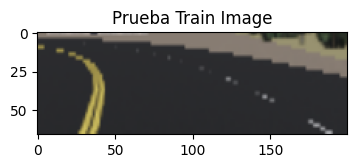

In [232]:
# Generar un índice aleatorio dentro del rango del número de rutas
index = random.randrange(0, len(paths))

# Imprimir la ruta en el índice generado aleatoriamente
print(paths[index])

# Mostrar la imagen en el índice generado aleatoriamente con el título 'Prueba Train Image' y redimensionada según SIZE
img_show(paths[index], title='Prueba Train Image', size=True)

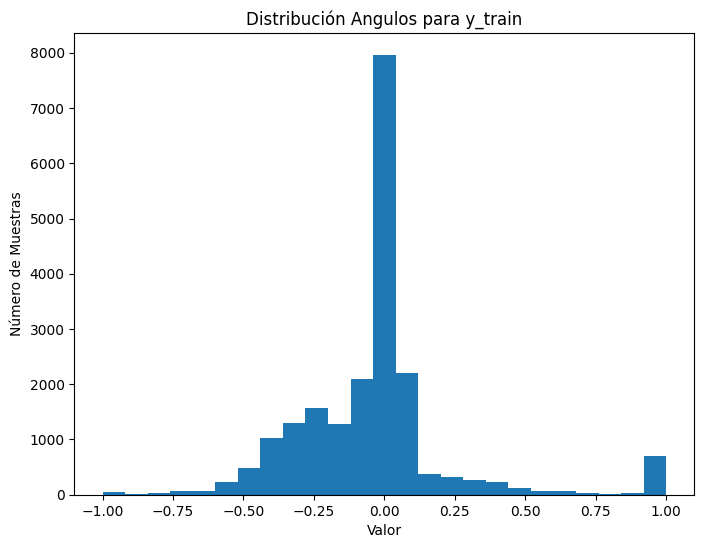

In [233]:
# Crear una nueva figura con el tamaño especificado
plt.figure(figsize=(8,6))

# Graficar un histograma de los datos de 'angles' con 25 bins
plt.hist(angles, bins=25)

# Establecer el título del gráfico
plt.title('Distribución de Ángulos para y_train')

# Establecer la etiqueta para el eje x
plt.xlabel("Valor")

# Establecer la etiqueta para el eje y
plt.ylabel("Número de Muestras")

# Mostrar el gráfico
plt.show()

## **Datos de Entrenamiento y Prueba**

___

In [234]:
# Función para cargar imágenes en una variable
def upload_dataset(path_list):
    """
    Función para cargar imágenes de una lista de rutas y devolverlas como una lista.

    Parámetros:
    path_list (list): Lista de rutas a los archivos de imagen.

    Retorna:
    output_list (list): Lista de imágenes cargadas y procesadas.
    """
    output_list = []
    for path in path_list:
        # Cargar la imagen en formato BGR
        img = cv2.imread(path)

        # Recortar la imagen para eliminar los primeros 35 píxeles
        img = img[35:,:,:]

        # Redimensionar la imagen según la variable global SIZE
        img = cv2.resize(img, SIZE)

        # Añadir la imagen procesada a la lista de salida
        output_list.append(img)
    return output_list

# Cargar las imágenes en X_train
X_train = np.array(upload_dataset(paths))

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba, con un tamaño de prueba del 10%
X_train, X_test, y_train, y_test = train_test_split(X_train, angles, test_size=0.1)

# Imprimir las formas de los conjuntos de entrenamiento y prueba
print('Formas del entrenamiento (Train)', X_train.shape, y_train.shape)
print('Formas del prueba (Test)', X_test.shape, y_test.shape)


Formas de Entrenamiento (Train) (18561, 66, 200, 3) (18561,)
Formas de Prueba (Test) (2063, 66, 200, 3) (2063,)


In [235]:
# Barajar los datos de entrenamiento para asegurar que el orden de los datos no afecte el proceso de aprendizaje
X_train, y_train = shuffle(X_train, y_train)

# Imprimir la forma de los datos de entrenamiento excluyendo la dimensión del tamaño del lote
# Esto es útil para confirmar las dimensiones de los datos que recibirá el modelo
print(X_train.shape[1:])

(66, 200, 3)


## **Modelo de Red Neuronal - NVIDIA Model**

___

In [236]:
# Inicializar un modelo Secuencial
model = Sequential()

# Añadir una capa Lambda para normalizar las imágenes de entrada a [-1,1] (suponiendo que las imágenes de entrada están escaladas a [0,255])
model.add(Lambda(lambda x: (x/127.5) - 1.0, input_shape=(66, 200, 3)))

# Añadir la primera capa de Convolución con 24 filtros de tamaño 5x5, función de activación ReLU y paso de 2
model.add(Conv2D(filters= 24, kernel_size=(5,5), activation='relu', strides=(2,2)))

# Añadir la segunda capa de Convolución con 36 filtros de tamaño 5x5, función de activación ReLU y paso de 2
model.add(Conv2D(filters= 36, kernel_size=(5,5), activation='relu', strides=(2,2)))

# Añadir la tercera capa de Convolución con 48 filtros de tamaño 5x5, función de activación ReLU y paso de 2
model.add(Conv2D(filters= 48, kernel_size=(5,5), activation='relu', strides=(2,2)))

# Añadir la cuarta capa de Convolución con 64 filtros de tamaño 3x3, función de activación ReLU
model.add(Conv2D(filters= 64, kernel_size=(3,3), activation='relu'))

# Añadir la quinta capa de Convolución con 64 filtros de tamaño 3x3, función de activación ReLU
model.add(Conv2D(filters= 64, kernel_size=(3,3), activation='relu'))

# Añadir una capa de Dropout para evitar el sobreajuste, desactiva el 50% de las neuronas
model.add(Dropout(0.5))

# Aplanar la salida del tensor de la capa anterior
model.add(Flatten())

# Añadir una capa Densa con 100 neuronas y función de activación ReLU
model.add(Dense(units= 100, activation= 'relu'))

# Añadir una capa Densa con 50 neuronas y función de activación ReLU
model.add(Dense(units= 50, activation= 'relu'))

# Añadir una capa Densa con 10 neuronas y función de activación ReLU
model.add(Dense(units= 10, activation= 'relu'))

# Añadir una capa Densa con 1 neurona y función de activación tanh (capa de salida)
model.add(Dense(units= 1, activation= 'tanh'))

# Compilar el modelo con el optimizador Adam y la función de pérdida de error cuadrático medio
model.compile(Adam(learning_rate= 0.001), loss='mse')

# Imprimir el resumen del modelo
print(model.summary())

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_20 (Lambda)              │ (None, 66, 200, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_102 (Conv2D)             │ (None, 31, 98, 24)     │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_103 (Conv2D)             │ (None, 14, 47, 36)     │        21,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_104 (Conv2D)             │ (None, 5, 22, 48)      │        43,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_105 (Conv2D)             │ (None, 3, 20, 64)      │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_106 (Conv2D)             │ (None, 1, 18, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1, 18, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 100)            │       115,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252,219 (985.23 KB)

 Trainable params: 252,219 (985.23 KB)

 Non-trainable params: 0 (0.00 B)

None


## **Entrenamiento del Modelo y Validación**

___

In [237]:
# Entrenar el modelo con los datos de entrenamiento
# Parámetros:
# X_train: datos de entrada para el entrenamiento
# y_train: datos de salida objetivo para el entrenamiento
# validation_split: fracción de los datos de entrenamiento que se usará como datos de validación
# epochs: número de veces que el algoritmo de aprendizaje recorrerá todo el conjunto de datos de entrenamiento
# batch_size: número de muestras a procesar antes de actualizar los parámetros internos del modelo
# verbose: modo de verbosidad, 1 = mostrar barra de progreso, 0 = silencioso
# shuffle: si se deben barajar los datos de entrenamiento antes de cada época
history = model.fit(
    X_train, y_train, validation_split=0.2, 
    epochs=20, batch_size=300, verbose=1, shuffle=True 
)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 396ms/step - loss: 0.0673 - val_loss: 0.0359
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 383ms/step - loss: 0.0342 - val_loss: 0.0303
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 408ms/step - loss: 0.0279 - val_loss: 0.0287
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 385ms/step - loss: 0.0262 - val_loss: 0.0283
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 387ms/step - loss: 0.0252 - val_loss: 0.0261
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 382ms/step - loss: 0.0230 - val_loss: 0.0243
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 407ms/step - loss: 0.0234 - val_loss: 0.0228
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 410ms/step - loss: 0.0222 - val_loss: 0.0226
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 431ms/step - loss: 0.0205 - val_loss: 0.0209
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 398ms/step - loss: 0.0203 - val_loss: 0.0229
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 400ms/step - loss: 0.0200 - val_loss: 0.0204
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 23

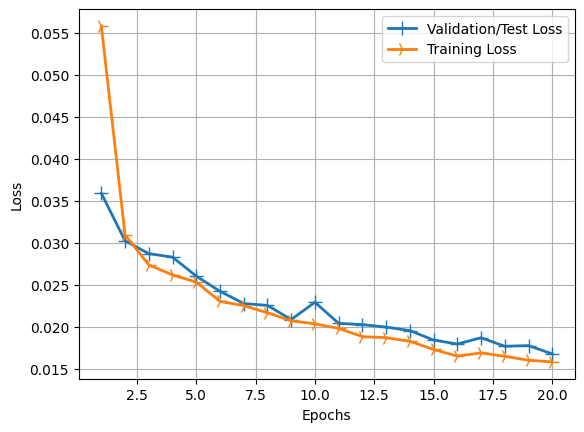

In [238]:
# Extraer el historial del proceso de entrenamiento del modelo
history_dict = history.history

# Extraer los valores de pérdida del historial
loss_values = history_dict['loss']

# Extraer los valores de pérdida de validación del historial
val_loss_values = history_dict['val_loss']

# Crear un rango de épocas desde 1 hasta el número de valores de pérdida más 1
epochs = range(1, len(loss_values) + 1)

# Graficar los valores de pérdida de validación contra las épocas
line1 = plt.plot(epochs, val_loss_values, label='Pérdida de Validación/Prueba')

# Graficar los valores de pérdida de entrenamiento contra las épocas
line2 = plt.plot(epochs, loss_values, label='Pérdida de Entrenamiento') 

# Establecer las propiedades para la línea de pérdida de validación
plt.setp(line1, linewidth=2.0, marker='+', markersize=10.0)

# Establecer las propiedades para la línea de pérdida de entrenamiento
plt.setp(line2, linewidth=2.0, marker='4', markersize=10.0)

# Establecer la etiqueta para el eje x
plt.xlabel('Épocas')

# Establecer la etiqueta para el eje y
plt.ylabel('Pérdida')

# Habilitar la cuadrícula en el gráfico
plt.grid(True)

# Añadir una leyenda al gráfico
plt.legend()

# Mostrar el gráfico
plt.show()


In [239]:
# Guardar el modelo entrenado
model.save("gear_fourth.keras")


In [109]:
# Cargar el modelo guardado
new_model = load_model("chido_model.keras", safe_mode=False)


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 20 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


train_images\M-2024-06-21_16-40-2920.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Prediccion de la Red: 0.8437 
Control real: 1.0000
Error: 0.1563


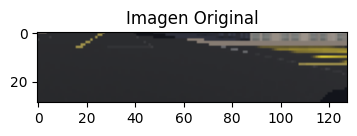

In [181]:
# Cargamos la imagen de prueba
index = random.randrange(0, len(paths))
print(paths[index])
ruta = paths[index]
valor = angles[index]
prueba = np.array(upload_dataset([ruta]))
img_show(ruta, title='Imagen Original')

# Realizamos la predicción con la imagen utilizando la red cargada
prediction = new_model.predict(prueba)[0][0]
print(f'Predicción de la Red: {prediction:.4f} \nControl real: {valor:.4f}')
print(f'Error: {abs(prediction-valor):.4f}')